# Imports 

In [1]:
## Essential Imports: 
import os
import numpy as np
import qp
import tables_io
from pathlib import Path 
from pzflow.examples import get_galaxy_data
import ceci

## RAIL-Specific Imports: 
import rail


import rail.creation 
import rail.creation.engines
from rail.creation.engines.flowEngine import FlowModeler, FlowCreator, FlowPosterior
from rail.core.data import TableHandle
from rail.core.stage import RailStage

from rail.estimation.algos.train_z import TrainZEstimator, TrainZInformer
from rail.estimation.algos.pzflow_nf import PZFlowInformer, PZFlowEstimator   


from rail.evaluation.evaluator import Evaluator


## Data Storage: 
DS = RailStage.data_store
DS.__class__.allow_overwrite = True


### CMNN, PZFlow, FlexZBoost, GPZ, trainz for control

In [2]:
## these don't work in rail_6-4-24, but they do in rail---new


from rail.creation.degradation.lsst_error_model import LSSTErrorModel
from rail.creation.degradation.spectroscopic_degraders import InvRedshiftIncompleteness
from rail.core.utilStages import ColumnMapper, TableConverter
from rail.estimation.algos.cmnn import Inform_CMNNPDF, CMNNPDF
from rail.estimation.algos.gpz import GPzInformer, GPzEstimator 
from rail.estimation.algos.flexzboost import FlexZBoostInformer, FlexZBoostEstimator  

In [2]:
#from rail.stages import *
#rail.stages.import_and_attach_all()
#for val in RailStage.pipeline_stages.values():
#    print(val[0])

# Model

In [2]:
import pandas as pd 
simpath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/rubin_roman_cat_galaxy_10307.parquet"
simdf = pd.read_parquet(simpath)
simdf


,galaxy_id,ra,dec,redshift,lsst_flux_u,lsst_flux_g,lsst_flux_r,lsst_flux_i,lsst_flux_z,lsst_flux_y
0,10307000647975,11.004215,-43.691749,0.977593,4.193303e-06,3.109506e-05,4.769407e-05,7.665075e-05,9.556565e-05,5.899129e-05
1,10307000647976,10.457251,-43.270133,0.986301,4.719124e-08,2.422614e-07,2.247910e-07,2.362558e-07,2.256190e-07,1.225624e-07
2,10307000647977,10.461233,-43.270285,0.986078,4.600807e-06,2.349252e-05,2.177404e-05,2.256752e-05,2.132510e-05,1.184524e-05
3,10307000647978,10.457563,-43.269365,0.985956,1.401118e-05,1.035321e-04,1.502447e-04,2.294925e-04,2.763348e-04,1.711969e-04
4,10307000647979,10.456033,-43.270402,0.986107,2.602337e-06,1.337752e-05,1.248427e-05,1.325030e-05,1.277432e-05,6.953721e-06
...,...,...,...,...,...,...,...,...,...,...
3561872,10307200155679,9.317343,-43.856524,2.003271,9.875664e-08,4.294199e-07,3.710233e-07,2.484436e-07,1.801343e-07,8.872853e-08
3561873,10307200155681,9.858846,-43.445420,2.017630,1.103310e-07,5.396969e-07,4.799532e-07,3.244082e-07,2.389266e-07,1.203854e-07
3561874,10307200155684,9.858881,-43.445009,2.019635,8.232293e-08,3.657772e-07,3.192164e-07,2.142712e-07,1.556855e-07,7.733667e-08
3561875,10307200155686,9.857731,-43.444477,2.017019,1.060606e-07,5.269599e-07,4.720781e-07,3.202059e-07,2.378822e-07,1.210272e-07


In [3]:
zero_point_dict ={"u":12.627880975839947,"g":14.486360566315488,
"r":14.324886825965237,"i":13.998598224053055,
"z":13.612736383992512,"y":12.785119907991263}

def flux_to_mag(flux, band):
    zero = zero_point_dict[band]
    return zero - 2.5*np.log10(flux)

In [4]:
u_band_flux = flux_to_mag(simdf['lsst_flux_u'], 'u')
g_band_flux = flux_to_mag(simdf['lsst_flux_g'], 'g')
r_band_flux = flux_to_mag(simdf['lsst_flux_r'], 'r')
i_band_flux = flux_to_mag(simdf['lsst_flux_i'], 'i')
z_band_flux = flux_to_mag(simdf['lsst_flux_z'], 'z')
y_band_flux = flux_to_mag(simdf['lsst_flux_y'], 'y')

In [5]:
simdf.insert(10, "mag_u_lsst", u_band_flux, True)
simdf.insert(11, "mag_g_lsst", g_band_flux, True)
simdf.insert(12, "mag_r_lsst", r_band_flux, True)
simdf.insert(13, "mag_i_lsst", i_band_flux, True)
simdf.insert(14, "mag_z_lsst", z_band_flux, True)
simdf.insert(15, "mag_y_lsst", y_band_flux, True)
simdf

,galaxy_id,ra,dec,redshift,lsst_flux_u,lsst_flux_g,lsst_flux_r,lsst_flux_i,lsst_flux_z,lsst_flux_y,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,10307000647975,11.004215,-43.691749,0.977593,4.193303e-06,3.109506e-05,4.769407e-05,7.665075e-05,9.556565e-05,5.899129e-05,26.071491,25.754631,25.128727,24.287308,23.661983,23.358150
1,10307000647976,10.457251,-43.270133,0.986301,4.719124e-08,2.422614e-07,2.247910e-07,2.362558e-07,2.256190e-07,1.225624e-07,30.943226,31.025650,30.945438,30.565142,30.229298,30.064226
2,10307000647977,10.461233,-43.270285,0.986078,4.600807e-06,2.349252e-05,2.177404e-05,2.256752e-05,2.132510e-05,1.184524e-05,25.970795,26.059036,25.980042,25.614889,25.290508,25.101261
3,10307000647978,10.457563,-43.269365,0.985956,1.401118e-05,1.035321e-04,1.502447e-04,2.294925e-04,2.763348e-04,1.711969e-04,24.761694,24.448673,23.882889,23.096676,22.509148,22.201382
4,10307000647979,10.456033,-43.270402,0.986107,2.602337e-06,1.337752e-05,1.248427e-05,1.325030e-05,1.277432e-05,6.953721e-06,26.589472,26.670422,26.583981,26.193033,25.846893,25.679577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3561872,10307200155679,9.317343,-43.856524,2.003271,9.875664e-08,4.294199e-07,3.710233e-07,2.484436e-07,1.801343e-07,8.872853e-08,30.141464,30.404156,30.401382,30.510529,30.473743,30.414961
3561873,10307200155681,9.858846,-43.445420,2.017630,1.103310e-07,5.396969e-07,4.799532e-07,3.244082e-07,2.389266e-07,1.203854e-07,30.021137,30.155985,30.121891,30.220869,30.167076,30.083685
3561874,10307200155684,9.858881,-43.445009,2.019635,8.232293e-08,3.657772e-07,3.192164e-07,2.142712e-07,1.556855e-07,7.733667e-08,30.339081,30.578320,30.564674,30.671188,30.632118,30.564157
3561875,10307200155686,9.857731,-43.444477,2.017019,1.060606e-07,5.269599e-07,4.720781e-07,3.202059e-07,2.378822e-07,1.210272e-07,30.063995,30.181917,30.139851,30.235025,30.171833,30.077913


In [6]:
sim_outpath = sim_outpath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/rubin_roman_catalog.pq"
simdf.to_parquet(sim_outpath)

non-repeating random numbers are:


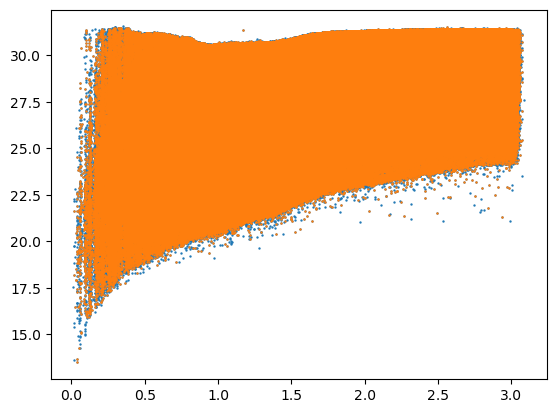

In [7]:
import numpy as np

# importing random module
import random
# getting numbers from 0 to 100
inputNumbers =range(0,3561877)
# printing 4 random numbers from the given range of numbers which are
# non-repeating using sample() function
print("non-repeating random numbers are:")
rands = list(set(random.sample(inputNumbers, 2000000)))
cut_df = simdf.drop(rands)

import matplotlib.pyplot as plt

plt.scatter(simdf['redshift'], simdf['mag_y_lsst'], s=0.5)
plt.scatter(cut_df['redshift'], cut_df['mag_y_lsst'], s=0.5)


In [8]:
cut_df

,galaxy_id,ra,dec,redshift,lsst_flux_u,lsst_flux_g,lsst_flux_r,lsst_flux_i,lsst_flux_z,lsst_flux_y,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,10307000647975,11.004215,-43.691749,0.977593,4.193303e-06,3.109506e-05,4.769407e-05,7.665075e-05,9.556565e-05,5.899129e-05,26.071491,25.754631,25.128727,24.287308,23.661983,23.358150
3,10307000647978,10.457563,-43.269365,0.985956,1.401118e-05,1.035321e-04,1.502447e-04,2.294925e-04,2.763348e-04,1.711969e-04,24.761694,24.448673,23.882889,23.096676,22.509148,22.201382
4,10307000647979,10.456033,-43.270402,0.986107,2.602337e-06,1.337752e-05,1.248427e-05,1.325030e-05,1.277432e-05,6.953721e-06,26.589472,26.670422,26.583981,26.193033,25.846893,25.679577
5,10307000647980,10.912042,-43.582034,0.985913,1.096747e-05,5.619271e-05,5.296560e-05,5.638254e-05,5.481578e-05,3.068750e-05,25.027615,25.112160,25.014904,24.620735,24.265472,24.067717
7,10307000647982,10.523431,-43.327557,0.990095,2.510978e-07,1.289475e-06,1.194322e-06,1.249475e-06,1.195966e-06,6.511477e-07,29.128273,29.210327,29.132084,28.756779,28.418440,28.250921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3561870,10307200155676,10.146258,-43.154766,1.978221,9.313582e-07,4.216819e-06,3.663647e-06,2.465956e-06,1.813188e-06,8.991959e-07,27.705090,27.923897,27.915104,28.018635,27.966629,27.900486
3561872,10307200155679,9.317343,-43.856524,2.003271,9.875664e-08,4.294199e-07,3.710233e-07,2.484436e-07,1.801343e-07,8.872853e-08,30.141464,30.404156,30.401382,30.510529,30.473743,30.414961
3561873,10307200155681,9.858846,-43.445420,2.017630,1.103310e-07,5.396969e-07,4.799532e-07,3.244082e-07,2.389266e-07,1.203854e-07,30.021137,30.155985,30.121891,30.220869,30.167076,30.083685
3561874,10307200155684,9.858881,-43.445009,2.019635,8.232293e-08,3.657772e-07,3.192164e-07,2.142712e-07,1.556855e-07,7.733667e-08,30.339081,30.578320,30.564674,30.671188,30.632118,30.564157


In [9]:
import pandas as pd

cut_outpath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/1.5e6_cut_rubin_roman_catalog.pq"
cut_df.to_parquet(cut_outpath)
cut_data = pd.read_parquet(cut_outpath)
cut_data

,galaxy_id,ra,dec,redshift,lsst_flux_u,lsst_flux_g,lsst_flux_r,lsst_flux_i,lsst_flux_z,lsst_flux_y,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,10307000647975,11.004215,-43.691749,0.977593,4.193303e-06,3.109506e-05,4.769407e-05,7.665075e-05,9.556565e-05,5.899129e-05,26.071491,25.754631,25.128727,24.287308,23.661983,23.358150
3,10307000647978,10.457563,-43.269365,0.985956,1.401118e-05,1.035321e-04,1.502447e-04,2.294925e-04,2.763348e-04,1.711969e-04,24.761694,24.448673,23.882889,23.096676,22.509148,22.201382
4,10307000647979,10.456033,-43.270402,0.986107,2.602337e-06,1.337752e-05,1.248427e-05,1.325030e-05,1.277432e-05,6.953721e-06,26.589472,26.670422,26.583981,26.193033,25.846893,25.679577
5,10307000647980,10.912042,-43.582034,0.985913,1.096747e-05,5.619271e-05,5.296560e-05,5.638254e-05,5.481578e-05,3.068750e-05,25.027615,25.112160,25.014904,24.620735,24.265472,24.067717
7,10307000647982,10.523431,-43.327557,0.990095,2.510978e-07,1.289475e-06,1.194322e-06,1.249475e-06,1.195966e-06,6.511477e-07,29.128273,29.210327,29.132084,28.756779,28.418440,28.250921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3561870,10307200155676,10.146258,-43.154766,1.978221,9.313582e-07,4.216819e-06,3.663647e-06,2.465956e-06,1.813188e-06,8.991959e-07,27.705090,27.923897,27.915104,28.018635,27.966629,27.900486
3561872,10307200155679,9.317343,-43.856524,2.003271,9.875664e-08,4.294199e-07,3.710233e-07,2.484436e-07,1.801343e-07,8.872853e-08,30.141464,30.404156,30.401382,30.510529,30.473743,30.414961
3561873,10307200155681,9.858846,-43.445420,2.017630,1.103310e-07,5.396969e-07,4.799532e-07,3.244082e-07,2.389266e-07,1.203854e-07,30.021137,30.155985,30.121891,30.220869,30.167076,30.083685
3561874,10307200155684,9.858881,-43.445009,2.019635,8.232293e-08,3.657772e-07,3.192164e-07,2.142712e-07,1.556855e-07,7.733667e-08,30.339081,30.578320,30.564674,30.671188,30.632118,30.564157


In [3]:
os.chdir('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test')

def makeModel():
    #path to access the data 
    DATA_DIR =  Path().resolve() / 'data' #"/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data" #"Path().resolve() / "data"
    #DATA_DIR.mkdir(exist_ok=True)

    print(type(DATA_DIR))

    catalog_file = DATA_DIR / "5e5_cut_rubin_roman_catalog.pq" #"base_catalog.pq"

    print(type(catalog_file))
    print(catalog_file)

    bands = ['u','g','r','i','z','y']
    band_dict = {band:f'mag_{band}_lsst' for band in bands}
    band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}
    band_dict_err = {f'mag_err_{band}_lsst' for band in bands}
    
    #array of galaxies w/ 7 attributes for each: redshift & ugrizy
    # catalog = get_galaxy_data().rename(band_dict, axis=1) 

    #turns array into a table 
    # tables_io.write(catalog, str(catalog_file.with_suffix("")), catalog_file.suffix[1:])

    catalog_file = str(catalog_file)
    flow_file = str(DATA_DIR / "5e5_trained_flow.pkl")

    print(flow_file)

    #we set up the stage 
    flow_modeler_params = {
        "name": "flow_modeler",
        "input": catalog_file,
        "model": flow_file,
        "seed": 0,
        "phys_cols": {"redshift": [0, 3]},
        "phot_cols": {
            "mag_u_lsst": [17, 28],#35],
            "mag_g_lsst": [16, 28],#32],
            "mag_r_lsst": [15, 28], #30],
            "mag_i_lsst": [15, 28], # 30],
            "mag_z_lsst": [14, 28], # 29],
            "mag_y_lsst": [14, 28],
        },
        "calc_colors": {"ref_column_name": "mag_i_lsst"},
    }
    flow_modeler = FlowModeler.make_stage(**flow_modeler_params)
    return flow_modeler, flow_file ##.get_handle("model")

In [48]:
# !open ~/miniforge3/envs/rail_6-4-24/lib/python3.10/site-packages/rail/creation/engines/

In [47]:
# !open ~/miniforge3/envs/rail_6-4-24/lib/python3.10/site-packages/rail/estimation/

/Users/alicec03/miniforge3/envs/rail_6-4-24/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
## try to figure out where the estimation directory for this env is from the line above... [...]/rail/estimation/ [stuff] ? 

In [4]:
modelData, flow_file = makeModel() 

<class 'pathlib.PosixPath'>
<class 'pathlib.PosixPath'>
/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/5e5_cut_rubin_roman_catalog.pq
/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/5e5_trained_flow.pkl


In [4]:
modelData.fit_model()

Inserting handle into data store.  input: /Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/5e5_cut_rubin_roman_catalog.pq, flow_modeler
column_list None
Training 30 epochs 
Loss:
(0) 22.3132
(1) -0.3964
(2) -4.2442
(3) -5.9984
(4) -7.8293
(5) -1.2588
(6) -6.6685
(7) -9.6992
(8) -8.4955
(9) -6.8108
(10) -8.0779
(11) -9.7546
(12) -10.5812
(13) -10.1483
(14) -10.8023
(15) -9.8592
(16) -9.9762
(17) -10.2646
(18) -9.1124
(19) -10.5812
(20) -11.5815
(21) -11.8530
(22) -9.6383
(23) -11.7712
(24) -9.9741
(25) -10.4749
(26) -11.9180
(27) -10.1776
(28) -9.6486
(29) -9.8225
(30) -12.1871
Inserting handle into data store.  model_flow_modeler: /Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/inprogress_trained_flow.pkl, flow_modeler


# Make Training Set and Test Set 

In [5]:
def spec_trainSet(ntrain, seed):
    data = FlowCreator.make_stage(
            name = 'spec_train_set',
            model = flow_file,
            n_samples = ntrain,
            seed = seed 
    )
    return data 

def invz_trainSet(ntrain, seed):
    data = FlowCreator.make_stage(
            name = 'invz_train_set',
            model = flow_file,
            n_samples = ntrain,
            seed = seed 
    )
    return data 


spec_train_data = spec_trainSet(1e6, 17) #1000000, 17)
invz_train_data = invz_trainSet(100000, 17)

Inserting handle into data store.  model: /Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/5e5_trained_flow.pkl, spec_train_set


In [6]:
def testSet(ntest, seed):
    data = FlowCreator.make_stage(
            name = 'test_set',
            model = flow_file,
            n_samples = ntest,
            seed = seed 
    )
    return data #.sample(ntest, seed)

test_data = testSet(10000, 39)

# Degraders

## Inverse Redshift Incompleteness

In [7]:
def invRedshift(pivot = 1.0):
    assert type(pivot) == float 
    degr = InvRedshiftIncompleteness.make_stage(
        name = 'inv_redshift',
        pivot_redshift = pivot
    )
    return degr 




## LSST Error 

In [8]:
bands = ['u','g','r','i','z','y']
band_dict = {band:f'mag_{band}_lsst' for band in bands}

def lsstError(dict, seed): 
    deg = LSSTErrorModel.make_stage(
        name='lsst_error',
        renameDict= dict, 
        ndFlag=np.nan,
        seed=seed,
    )
    return deg 

def lsstError_0(dict, seed): 
    deg = LSSTErrorModel.make_stage(
        name='lsst_error_0',
        renameDict= dict, 
        ndFlag=np.nan,
        seed=seed
    )
    return deg 

def lsstError_null(dict, seed): 
    deg = LSSTErrorModel.make_stage(
        name = 'lsst_error_null', 
        renameDict= dict, 
        ndFlag=np.nan,
        seed=seed,
        nYrObs = 100000000,
        tvis = 100000000,
        sigmaSys= 0.000
    ) 
    return deg

## Survey-Based Degraders

In [9]:
from rail.creation.degradation.spectroscopic_selections import *

def specSelectBOSS(ntrain):
    degr = SpecSelection_BOSS.make_stage(
        name = 'specselection_boss',
        N_tot = ntrain
    )
    return degr 

def specSelectDEEP2(ntrain):
    degr = SpecSelection_DEEP2.make_stage(
        name = 'specselection_deep2',
        N_tot = ntrain
    )
    return degr 

def specSelectGAMA(ntrain):
    degr = SpecSelection_GAMA.make_stage(
        name = 'specselection_gama',
        N_tot = ntrain
    )
    return degr 

def specSelectHSC(ntrain):
    degr = SpecSelection_HSC.make_stage(
        name = 'specselection_HSC',
        N_tot = ntrain
    )
    return degr 

def specSelectVVDSf02(ntrain):
    degr = SpecSelection_VVDSf02.make_stage(
        name = 'specselection_VVDSf02',
        N_tot = ntrain
    )
    return degr 

def specSelectzCOSMOS(ntrain):
    degr = SpecSelection_zCOSMOS.make_stage(
        name = 'specselection_zCOSMOS',
        N_tot = ntrain
    )
    return degr 

In [15]:
# spec_dict = {'BOSS': specSelectBOSS, 
#              'DEEP2': specSelectDEEP2, 
#              'GAMA': specSelectGAMA,
#              'HSC': specSelectHSC, 
#              'VVDSf02': specSelectVVDSf02, 
#              'zCOSMOS': specSelectzCOSMOS } 

# Posteriors 

In [79]:
## make test data 
os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/")

lsstErr = lsstError(band_dict, 39)
lsstErr.connect_input(test_data)

lsstErr_test_data = lsstErr(test_data.sample(10000, 39), seed=39)


Inserting handle into data store.  output_test_set: inprogress_output_test_set.pq, test_set
Inserting handle into data store.  output_lsst_error: inprogress_output_lsst_error.pq, lsst_error


In [77]:
# os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/at_scale_estimation")

# lsstErr_null = lsstError_null(band_dict, 172)
# lsstErr_null.connect_input(test_data)

# null_data = lsstErr_null(test_data.sample(10000, 17), seed=172)

# null_data


In [78]:
# os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/at_scale_estimation")

# lsstErr_null = lsstError_null(band_dict, 172)
# lsstErr_null.connect_input(invz_train_data)

# null_train_data = lsstErr_null(invz_train_data.sample(10000, 17), seed=172)

# null_train_data

In [80]:
import tables_io
import qp
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import pandas as pd

os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test")

lsstErr_testSet_posts = FlowPosterior.make_stage(name='lsstErr_test_data_posts', 
                                             column='redshift',
                                             grid = np.linspace(0, 2.5, 101),
                                             model=flow_file,
                                             data = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error.pq"
)

# lsstErr_test_pdfs = lsstErr_testSet_posts.get_posterior(lsstErr_deg_data, column='redshift')

# post_file = .read("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error (for posts).pq")

posts_file = DS.read_file('name', TableHandle, path="/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error.pq")

lsstErr_test_pdfs = lsstErr_testSet_posts.get_posterior(posts_file, column = 'redshift')

Inserting handle into data store.  output_lsstErr_test_data_posts: inprogress_output_lsstErr_test_data_posts.hdf5, lsstErr_test_data_posts


/Users/alicec03/miniforge3/envs/rail---new/lib/python3.11/site-packages/qp/interp_pdf.py:83: RuntimeWarning: invalid value encountered in divide
  self._ycumul = (self._ycumul.T / self._ycumul[:,-1]).T


### Plots

In [149]:
import h5py
import pandas as pd

file = h5py.File("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsstErr_testSet_posts.hdf5", 'r')
print(file['meta'].keys())

table = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error (for posts).pq")

table

<KeysViewHDF5 ['pdf_name', 'pdf_version', 'xvals']>


,redshift,mag_g_lsst,mag_g_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_u_lsst,mag_u_lsst_err,mag_y_lsst,mag_y_lsst_err,mag_z_lsst,mag_z_lsst_err
0,0.520948,27.374494,0.211640,25.684959,0.070899,25.954994,0.060779,NaN,NaN,24.964686,0.148859,25.701503,0.126073
1,0.970512,25.861015,0.056888,24.887539,0.034959,25.388159,0.036758,26.231575,0.232690,24.368417,0.088593,24.499278,0.043682
2,1.320268,26.796911,0.129428,25.527806,0.061683,26.321098,0.084024,29.770850,2.144325,24.540326,0.103018,25.117785,0.075592
3,1.035288,26.489168,0.099005,25.401373,0.055136,25.877703,0.056750,26.562947,0.304758,24.466978,0.096606,24.676015,0.051101
4,1.599862,26.402639,0.091771,26.180933,0.109677,26.393691,0.089570,26.002167,0.192183,25.819267,0.303473,25.547411,0.110259
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.188424,27.550561,0.244919,26.616389,0.159804,27.090805,0.164031,26.984455,0.423752,25.373730,0.210577,25.574843,0.112928
9996,0.678350,25.585286,0.044558,24.643624,0.028209,25.269635,0.033105,25.792986,0.161001,24.010129,0.064557,24.336864,0.037828
9997,0.364240,26.648873,0.113821,25.549677,0.062891,25.757072,0.050986,27.439980,0.592538,25.267265,0.192575,25.272837,0.086671
9998,0.960942,26.820437,0.132087,24.232563,0.019789,25.134620,0.029399,27.594492,0.660157,23.121956,0.029412,23.430820,0.017288


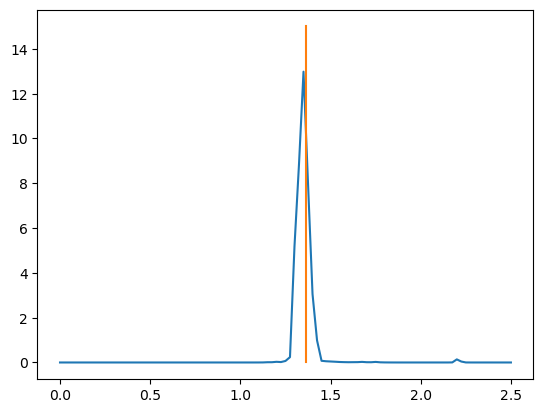

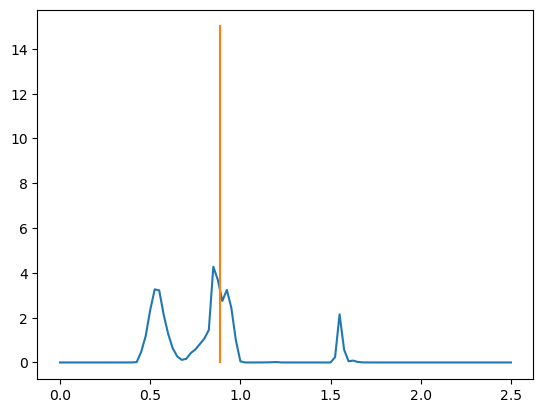

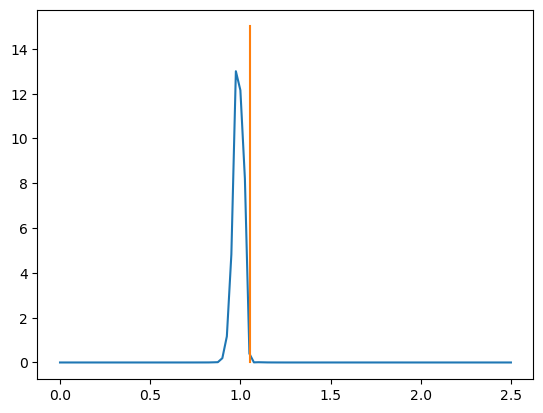

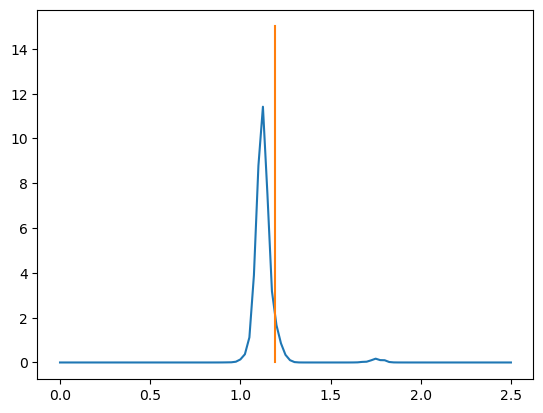

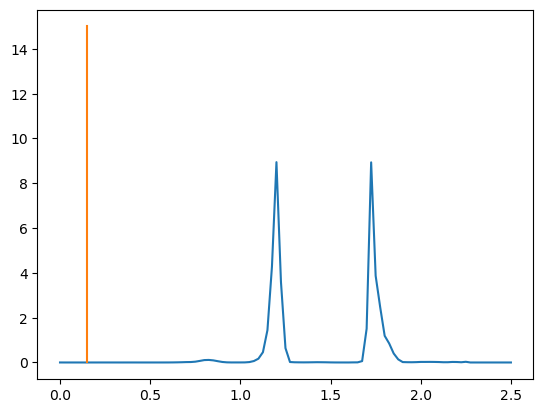

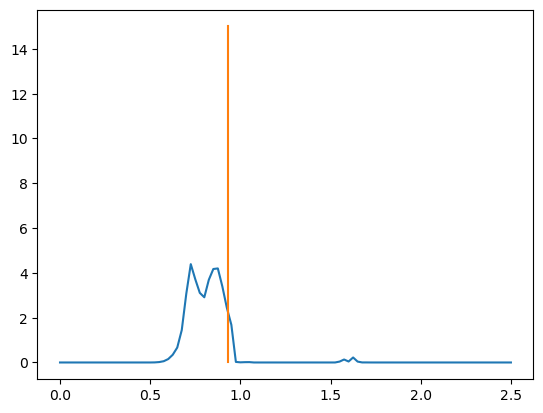

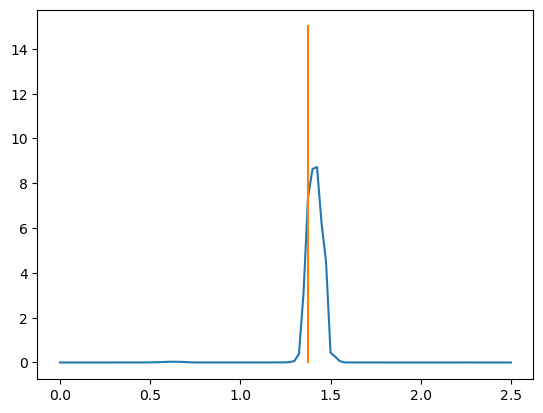

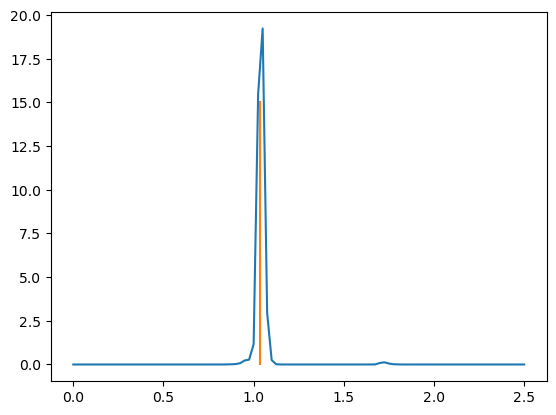

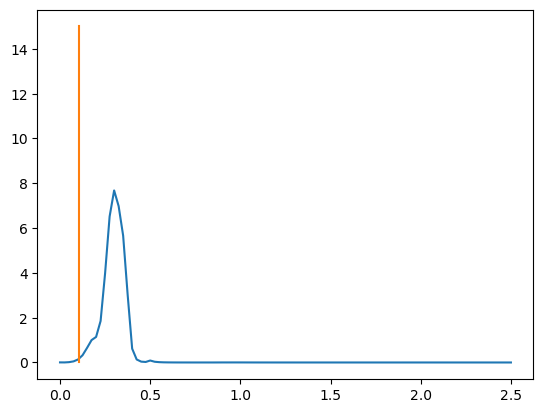

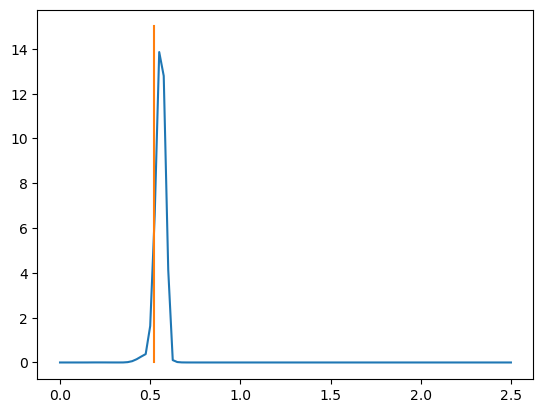

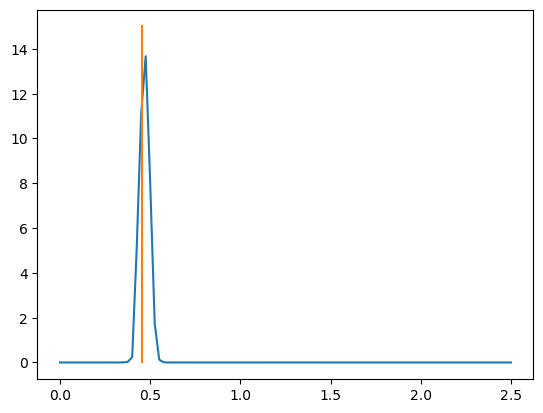

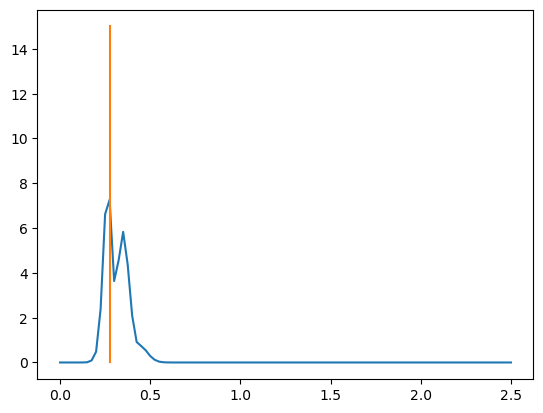

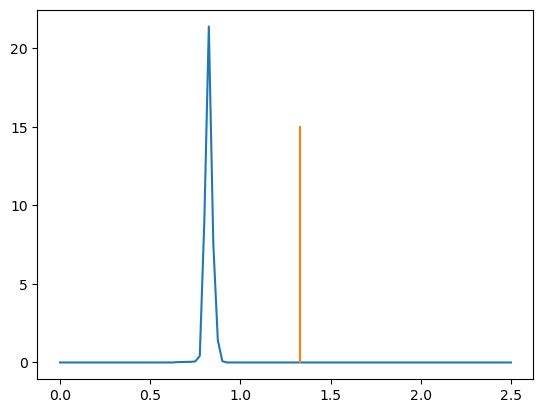

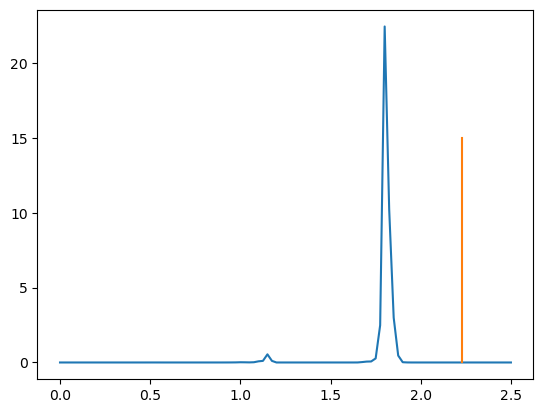

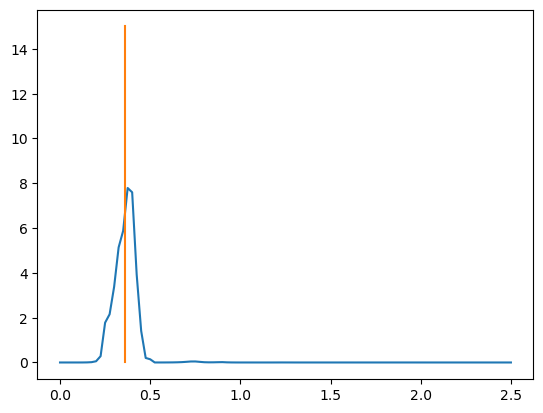

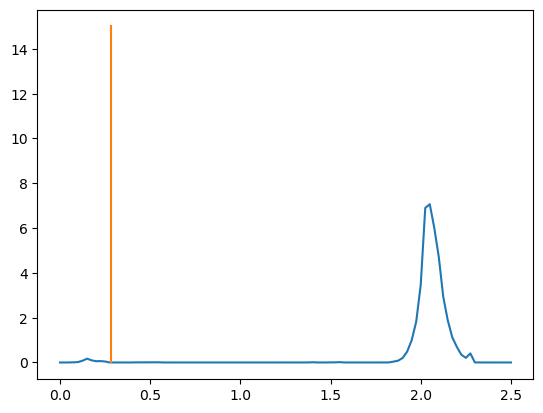

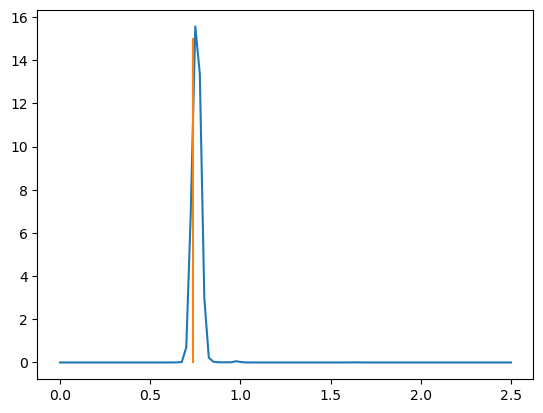

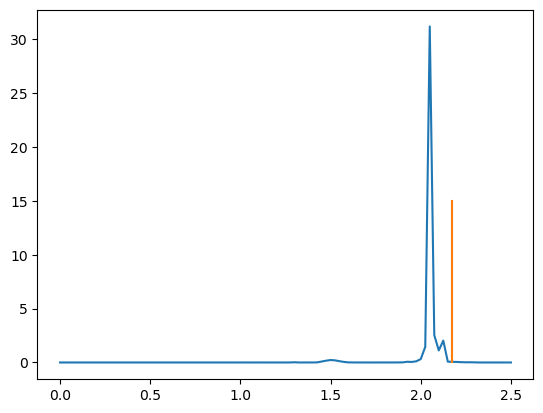

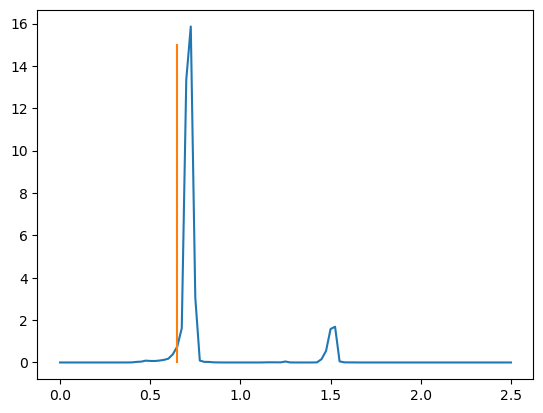

In [157]:
import matplotlib.pyplot as plt


for i in range(21, 40):

    plt.plot(file['meta']['xvals'][0], file['data']['yvals'][i])
    plt.plot(table['redshift'][i] * np.ones(len(file['meta']['xvals'][0])), np.linspace(0, 15, len(file['meta']['xvals'][0])))
    plt.show()

# Make tables

In [10]:
bands = ['u','g','r','i','z','y']
band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

def colRemapper_1(dict):
    col_remap = ColumnMapper.make_stage(
    name='col_remapper_1', 
    columns=dict,
    )
    return col_remap

def colRemapper_2(dict):
    col_remap = ColumnMapper.make_stage(
    name='col_remapper_2', 
    columns=dict,
    )
    return col_remap

def tableConverter():
    table_conv = TableConverter.make_stage(
    name='table_conv', 
    output_format='numpyDict',
    )
    return table_conv

In [11]:
# os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/at_scale_estimation/test_data")#remapped_test_set_lsst_err_only.pq"

# remap_null_train = DS.read_file("remapped_null_training_data", TableHandle, "./control_set_null_LSSTerr.pq")
# remap_data = colRemapper_1(band_dict_err)(remap_null_train)



# Inform & Estimate

In [11]:
def informTrainZ(deg):
    inf = TrainZInformer.make_stage(
    name = 'inform_TrainZ',
    model = deg+'_trainz.pkl',
    hdf5_groupname=""
    )
    return inf

def estimateTrainZ(deg):
    est = TrainZEstimator.make_stage(
    name = 'estimate_TrainZ',
    model = deg+'_trainz.pkl', 
    hdf5_groupname=""
    )
    return est

In [31]:
def informCMNN(deg):
    inf = Inform_CMNNPDF.make_stage(
    name = 'inform_CMNN',
    model = deg+'_cmnn.pkl',
    hdf5_groupname=""
    )
    return inf

def estimateCMNN(deg):
    est = CMNNPDF.make_stage(
    name = 'estimate_CMNN',
    model = deg+'_cmnn.pkl', 
    hdf5_groupname=""
    )
    return est

In [32]:
def informGPz(deg):
    inf = GPzInformer.make_stage(
    name = 'inform_GPz',
    model = deg+'_gpz.pkl',
    hdf5_groupname=""
    )
    return inf

def estimateGPz(deg):
    est = GPzEstimator.make_stage(
    name = 'estimate_GPz',
    model = deg+'_gpz.pkl', 
    hdf5_groupname=""
    )
    return est

In [33]:
def informFZBoost(deg):
    info = FlexZBoostInformer.make_stage(
    name ='inform_FZBoost', 
    model = deg+'_fzboost.pkl', 
    hdf5_groupname='',
    )
    return info

def estimateFZBoost(deg):
    est = FlexZBoostEstimator.make_stage(
    name='estimate_FZBoost', 
    nondetect_val=np.nan,
    model= deg+'_fzboost.pkl', 
    hdf5_groupname='',
    # aliases=dict(input='test_data', output='fzboost_estim'),
    nzbins = 100 
    )
    return est 

### PZFlow

In [19]:
# def informPZFlow():
#     inf = PZFlowInformer.make_stage(
#     name = 'inform_PZFlow',
#     model = 'pzflow.pkl',
#     hdf5_groupname=""
#     )
#     return inf

# def estimatePZFlow(info):
#     est = PZFlowEstimator.make_stage(
#     name = 'estimate_PZFlow',
#     model = 'pzflow.pkl', 
#     hdf5_groupname=""
#     )
#     return est

In [ ]:
## ONLY RUN THESE CELLS IN rail_6-4-24 AND ONLY FOR PZFlow; EVERYTHING ELSE RUNS IN rail---new ## 

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
import pandas as pd
from astropy.table import QTable, Table, Column
from collections import OrderedDict

In [2]:
import rail
import qp
from rail.core.data import TableHandle
from rail.core.stage import RailStage

In [3]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [4]:
dir = "/Users/alicec03/Desktop/Summer_Research/rail_pzflow/src"
os.chdir(dir)

from rail.estimation.algos.pzflow_nf_default import PZFlowInformer, PZFlowEstimator

pzflow_dict = dict(hdf5_groupname='', output_mode = 'not_default', )


In [29]:
def informPZFlow():
    inf = PZFlowInformer.make_stage(
    name = 'inform_PZFlow', 
    model = 'pzflow.pkl', 
    num_training_epochs = 150,
    **pzflow_dict
    )
    inf._aliases = dict()
    return inf 

def estimatePZFlow():
    est = PZFlowEstimator.make_stage(
    name='estimate_pzflow',
    model='pzflow.pkl',
    **pzflow_dict, 
    chunk_size = 15000
    )
    est._aliases = dict()
    return est 

In [31]:
import pandas as pd

In [32]:
df1 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs/VVDSf02/output_specselection_VVDSf02.pq")
df2 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs/VVDSf02/output_lsst_error_0.pq")

In [33]:
df2

,redshift,mag_g_lsst,mag_g_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_u_lsst,mag_u_lsst_err,mag_y_lsst,mag_y_lsst_err,mag_z_lsst,mag_z_lsst_err
4,1.068016,23.978469,0.011595,22.860390,0.007493,23.314348,0.007530,24.531861,0.053686,21.961038,0.011332,22.207543,0.007454
6,0.729724,24.271791,0.014487,21.572772,0.005326,22.558188,0.005782,25.978886,0.188455,20.646691,0.005927,20.985653,0.005360
13,1.206573,23.103431,0.006961,22.540720,0.006535,22.809979,0.006168,23.279126,0.018320,21.598146,0.008887,21.937022,0.006631
26,0.215827,22.794806,0.006230,21.783998,0.005459,22.063238,0.005352,23.812103,0.028652,21.490427,0.008339,21.655770,0.006052
52,0.689987,24.717080,0.020889,22.246049,0.005965,23.349481,0.007664,25.652222,0.142748,21.642794,0.009136,21.926291,0.006605
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999957,0.619409,24.688354,0.020387,23.322299,0.009799,23.897355,0.010719,25.338773,0.108888,22.966369,0.025677,23.104256,0.013302
999958,1.373877,26.298010,0.083706,23.456470,0.010741,25.293554,0.033811,27.964888,0.844511,22.196400,0.013526,22.912250,0.011513
999961,0.783317,25.258889,0.033402,22.301409,0.006054,23.643681,0.009057,32.276515,4.504955,21.443400,0.008122,21.800529,0.006320
999980,0.456077,23.431141,0.008157,21.429680,0.005260,21.917461,0.005278,24.940655,0.076896,20.753229,0.006097,21.126787,0.005451


In [34]:
lsu = df2.index[np.isnan(df2['mag_u_lsst']) ==True].tolist() 
lsg = df2.index[np.isnan(df2['mag_g_lsst']) ==True].tolist() 
lsr = df2.index[np.isnan(df2['mag_r_lsst']) ==True].tolist() 
lsi = df2.index[np.isnan(df2['mag_i_lsst']) ==True].tolist() 
lsz = df2.index[np.isnan(df2['mag_z_lsst']) ==True].tolist() 
lsy = df2.index[np.isnan(df2['mag_y_lsst']) ==True].tolist() 


# print(list(set(lsu+lsg + lsr+ lsi+lsz+lsy)))


In [37]:
col_names = ['mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst']

# loc = 0
# for loc in range(0, len(df2['redshift'])):
#     row = df2[loc:loc+1]
#     for name in col_names:
#         print(row[name])
#         #if np.isnan(row[name]) == True:
#             #print('AAA')
#     loc += 1

# loc = 15
# row = df2[loc:loc+1]
# #print(row)
# print(row['mag_g_lsst'])

In [40]:
ct = 0
for i in df2['mag_z_lsst']:
    if np.isnan(i) == True:
        ct += 1
        # print(i, ct)
print(str(ct)+ ' nans')

343 nans


In [31]:
data1 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/1.0/output_lsst_error_0.pq")
data2 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/1.0/output_inv_redshift.pq")

In [32]:
data1

,redshift,mag_g_lsst,mag_g_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_u_lsst,mag_u_lsst_err,mag_y_lsst,mag_y_lsst_err,mag_z_lsst,mag_z_lsst_err
0,0.966559,24.697981,0.020554,22.690358,0.006931,23.450827,0.008088,25.449445,0.119858,21.535051,0.008558,21.846427,0.006418
1,1.059953,25.621688,0.046017,24.197568,0.019213,24.823453,0.022434,26.151518,0.217748,23.274423,0.033632,23.495452,0.018242
2,0.570302,28.383380,0.471983,25.696458,0.071624,26.405758,0.090526,31.017384,3.282711,25.043283,0.159229,25.563890,0.111855
4,0.341016,26.144901,0.073134,25.286391,0.049785,25.359434,0.035836,26.514136,0.293040,25.130427,0.171511,25.008434,0.068623
5,0.712270,24.458110,0.016830,23.199302,0.009054,23.805980,0.010064,24.773335,0.066386,23.089466,0.028587,23.111844,0.013380
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,0.464899,26.762184,0.125594,25.813217,0.079409,25.891819,0.057465,32.937456,5.158052,25.129838,0.171425,25.346420,0.092465
99995,0.648156,28.863500,0.666268,25.634096,0.067777,26.697650,0.116870,27.369025,0.563287,24.914419,0.142563,25.310327,0.089577
99996,1.257911,26.128194,0.072063,25.453699,0.057758,25.807632,0.053327,25.838849,0.167406,24.394950,0.090685,24.862871,0.060318
99997,1.652583,26.951892,0.147925,25.471360,0.058670,25.992044,0.062809,NaN,NaN,24.499793,0.099426,24.991590,0.067607


In [33]:
data2

,redshift,mag_g_lsst,mag_i_lsst,mag_r_lsst,mag_u_lsst,mag_y_lsst,mag_z_lsst
0,0.966559,24.721041,22.692711,23.446445,25.300295,21.518806,21.846548
1,1.059953,25.584215,24.180773,24.818432,26.139088,23.199163,23.512583
2,0.570302,27.575546,25.843550,26.462980,28.492306,25.302023,25.566341
4,0.341016,26.198450,25.291866,25.400103,26.946693,24.973673,24.965878
5,0.712270,24.463943,23.197393,23.782991,24.921415,23.028093,23.084066
...,...,...,...,...,...,...,...
99994,0.464899,26.947382,25.712088,25.966135,27.622187,25.287737,25.510817
99995,0.648156,28.063946,25.650227,26.594429,29.282473,25.099009,25.411396
99996,1.257911,26.042486,25.415533,25.832323,26.238253,24.347881,24.835291
99997,1.652583,26.878645,25.496140,26.155291,28.357960,24.551855,24.988556


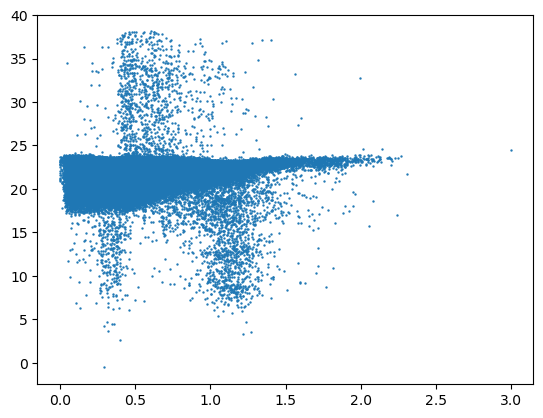

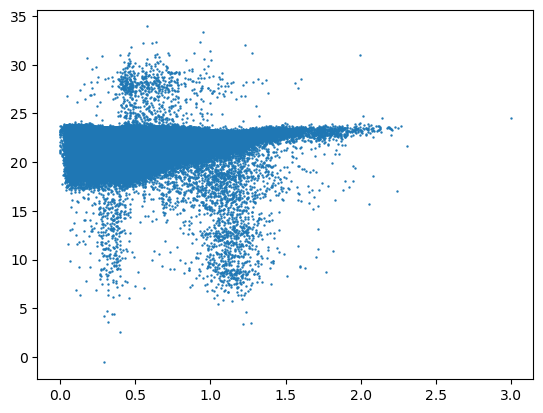

In [37]:
plt.scatter(df1['redshift'], df1['mag_z_lsst'], s=0.5)
plt.show()
plt.scatter(df2['redshift'], df2['mag_z_lsst'], s=0.5)
plt.show()

In [20]:
os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/outputs/BOSS/")
trainFile = DS.read_file("training_data", TableHandle, "./output_lsst_error_0.pq")

informPZFlow().inform(trainFile)

column_list None
Training 150 epochs 
Loss:
(0) inf
(1) inf
Training stopping after epoch 1 because training loss diverged.


In [42]:
os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs/1.0/")
testFile = DS.read_file('test_data', TableHandle, "./output_lsst_error.pq")
estimatePZFlow().estimate(testFile)

column_list None
Process 0 running estimator on chunk 0 - 10000


/Users/alicec03/miniforge3/envs/rail_6-4-24/lib/python3.10/site-packages/qp/interp_pdf.py:89: RuntimeWarning: invalid value encountered in divide
  self._ycumul = (self._ycumul.T / self._ycumul[:, -1]).T


Inserting handle into data store.  output_estimate_pzflow: inprogress_output_estimate_pzflow.hdf5, estimate_pzflow


In [44]:
import h5py

os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs/1.0/")
pzflow_out = h5py.File("./output_estimate_PZFlow.hdf5")

In [45]:
pzflow_out.keys()

<KeysViewHDF5 ['ancil', 'data', 'meta']>

In [58]:
# import ceci 

# pr = ceci.Pipeline.read(path_lst_1[0])#parent_dir+directory+"/invz=0.33672517538070684_lsstErr_pzflow.yml")
# pr.run()

# ## 1) terminal: go to path up to invz_lsstErr_pzflow, then run these 2 lines 
# ## 2)  make list/txt file with list of paths to files made by big F

# ## do 1) 
# ## open virtual env
# ## python 
# ## import ceci 
# ## run the 2 lines of code above 


# ### at the end we can put this into a .py file that we can run at the command line 

# ## %cd ? 

In [59]:
## more config parameters/better config parameters
## have to give path above to estimator model instead of get_handle('model')
## fix truncated parameter printing in help(...)

# Big F's

In [19]:
# ## for inverse redshift incompleteness:

# pivot_ls = [1.0, 1.4, 'LSSTerr_only']#, 'control'] 

# name_ls = ['BOSS', 'DEEP2', 'GAMA', 'HSC', 'VVDSf02', 'zCOSMOS']

In [38]:
# 'invz': invRedshift,

deg_ls = ['BOSS', 'DEEP2', 'GAMA', 'HSC', 'VVDSf02', 'zCOSMOS', 'invz=1.0', 'invz=1.4', 'LSSTerr_only', 'control']



In [16]:
ntrain = 1e6 # 10e6
seed = 17

deg_dict = {'BOSS': [specSelectBOSS(ntrain), lsstError_0(band_dict, seed)], 
            'DEEP2': [specSelectDEEP2(ntrain), lsstError_0(band_dict, seed)], 
            'GAMA': [specSelectGAMA(ntrain), lsstError_0(band_dict, seed)], 
            'HSC': [specSelectHSC(ntrain), lsstError_0(band_dict, seed)], 
            'VVDSf02': [specSelectVVDSf02(ntrain), lsstError_0(band_dict, seed)], 
            'zCOSMOS': [specSelectzCOSMOS(ntrain), lsstError_0(band_dict, seed)], 
            'invz=1.0': [invRedshift(1.0), lsstError_0(band_dict, seed)], 
            'invz=1.4': [invRedshift(1.4), lsstError_0(band_dict, seed)], 
            'LSSTerr_only': [lsstError_0(band_dict, seed)], 
            'control': [lsstError_null(band_dict, seed)],
            } 

In [17]:
lsstError = lsstError(band_dict, 39)
lsstError.connect_input(test_data)

Inserting handle into data store.  output_test_set: inprogress_output_test_set.pq, test_set


In [34]:
def bigF(est, deg, pathname): 
    bands = ['u','g','r','i','z','y']
    band_dict = {band: f"mag_{band}_lsst" for band in bands}
    band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

    inf_est_dict = {'TrainZ': [informTrainZ(deg), estimateTrainZ(deg)],
               'CMNN': [informCMNN(deg), estimateCMNN(deg)], 
               'GPz': [informGPz(deg), estimateGPz(deg)], 
               # 'PZFlow': [informPZFlow(), estimatePZFlow()], 
               'FZBoost': [informFZBoost(deg), estimateFZBoost(deg)] }
    
    if deg in ['BOSS', 'DEEP2', 'GAMA', 'HSC', 'VVDSf02', 'zCOSMOS']:
        training_data = spec_train_data
    
    if deg in ['invz=1.0', 'invz=1.4', 'LSSTerr_only', 'control']:
        training_data = invz_train_data

    degraders = deg_dict[deg]

    informer = inf_est_dict[est][0]
    estimator = inf_est_dict[est][1]

    pipe = ceci.Pipeline.interactive()
    stages = [training_data, 
              test_data, 
              lsstError, 
              informer, 
              estimator
              ]

    if len(degraders)==2:
        selection = degraders[0]
        lsst = degraders[1]
        stages.append(selection)
        stages.append(lsst)
        selection.connect_input(training_data)
        lsst.connect_input(selection)

    elif len(degraders)==1:
        lsst = degraders[0]
        stages.append(lsst)
        lsst.connect_input(training_data)

    remapper_1 = colRemapper_1(band_dict_err)
    remapper_2 = colRemapper_2(band_dict_err)

    if est == 'CMNN' or est == 'GPz':
        stages.append(remapper_1)
        stages.append(remapper_2)

        remapper_1.connect_input(lsst)
        informer.connect_input(remapper_1)

        remapper_2.connect_input(lsstError)
        estimator.connect_input(remapper_2, inputTag = 'input')

    else: 
        informer.connect_input(lsst)
        estimator.connect_input(lsstError, inputTag = 'input')

    estimator.connect_input(informer, inputTag = 'model')

    for stage in stages:
        pipe.add_stage(stage)

    pipe.initialize(
    dict(model=flow_file), dict(output_dir=".", log_dir=".", resume=False), None) 

    outpath = os.path.join(pathname, deg+'_'+est+'.yml')#"% s_.yml" % deg+'_'+est)
    pipe.save(outpath)
    return outpath 
    

In [19]:
def makeItHelperFunc(est):
    path = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"+est
    os.chdir(path)

    path_ls = []
    for key in deg_dict:
        os.chdir(path)
        working_path = os.path.join(path, key)
        os.makedirs(working_path, exist_ok = True)
        os.chdir(working_path)
        path_ls.append(bigF(est, key, working_path))
    
    return path_ls 

In [39]:
TrainZ_path_ls = makeItHelperFunc('TrainZ')

In [40]:
CMNN_path_ls = makeItHelperFunc("CMNN")

In [41]:
GPz_path_ls = makeItHelperFunc("GPz")

Inserting handle into data store.  model_inform_GPz: inprogress_BOSS_gpz.pkl, inform_GPz


In [42]:
FZBoost_path_ls = makeItHelperFunc("FZBoost")

Inserting handle into data store.  model_inform_FZBoost: inprogress_BOSS_fzboost.pkl, inform_FZBoost


In [29]:
# TrainZ_path = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ"
# os.chdir(TrainZ_path)


# TrainZ_path_ls = []
# for key in deg_dict:
#     os.chdir(TrainZ_path)
#     working_path = os.path.join(TrainZ_path, key)
#     os.makedirs(working_path, exist_ok = True)
#     os.chdir(working_path)
#     TrainZ_path_ls.append(bigF('TrainZ', key, working_path))

In [45]:
import ceci 

def runItHelperFunc(est, path_ls):
    path = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"+est 
    os.chdir(path)
    ct = 0
    for deg in deg_ls: 
        os.chdir(path+'/'+deg)
        pr = ceci.Pipeline.read(path_ls[ct])
        pr.run()
        ct += 1

In [46]:
runItHelperFunc('TrainZ', TrainZ_path_ls)


Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/5e5_trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/BOSS/BOSS_TrainZ_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out

Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/BOSS/BOSS_TrainZ_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing spec_train_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flow

In [48]:
runItHelperFunc('CMNN', CMNN_path_ls)


Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/5e5_trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/CMNN/BOSS/BOSS_CMNN_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out



Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/CMNN/BOSS/BOSS_CMNN_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing col_remapper_2
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.core.utilStages.ColumnMapper   --input=./output_lsst_error.pq   --name=col_remapper_2   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/CMNN/BOSS/BOSS_CMNN_config.yml   --output=./output_col_remapper_2.pq 
Output writing to ./col_remapper_2.out

Job col_remapper_2 has completed successfully!

Executing spec_train_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/U

In [49]:
runItHelperFunc('GPz', GPz_path_ls)


Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/5e5_trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/GPz/BOSS/BOSS_GPz_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out

Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/GPz/BOSS/BOSS_GPz_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing col_remapper_2
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.core.utilStages.ColumnMapper   --

In [50]:
runItHelperFunc('FZBoost', FZBoost_path_ls)


Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/5e5_trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/FZBoost/BOSS/BOSS_FZBoost_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out

Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/FZBoost/BOSS/BOSS_FZBoost_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing spec_train_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.

In [51]:
lets make an error 

SyntaxError: invalid syntax (477353185.py, line 1)

In [ ]:
import pandas as pd

deg_file = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/GAMA/output_specselection_gama.pq"
undeg_file = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/GAMA/output_spec_train_set.pq"
deg = pd.read_parquet(deg_file)
orig = pd.read_parquet(undeg_file)

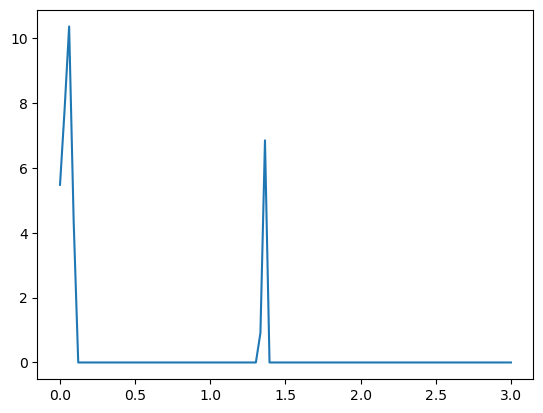

In [65]:
outpath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/FZBoost/zCOSMOS/output_estimate_FZBoost.hdf5"

import h5py
outfile = h5py.File(outpath)

import matplotlib.pyplot as plt

x = outfile['meta']['xvals'][0]
y = outfile['data']['yvals'][0]

plt.plot(outfile['meta']['xvals'][0], outfile['data']['yvals'][3])

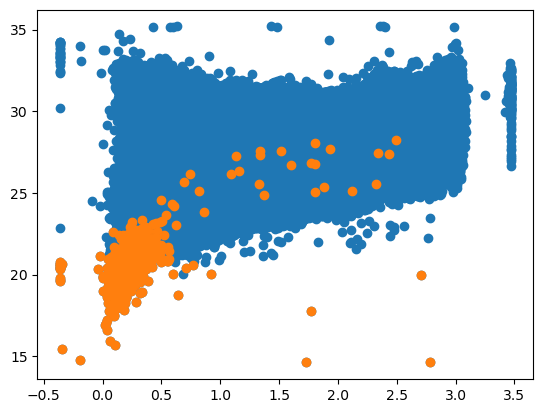

In [ ]:
import matplotlib.pyplot as plt


plt.scatter(orig['redshift'], orig['mag_u_lsst'])
plt.scatter(deg['redshift'], deg['mag_u_lsst'])

In [ ]:
len(deg['redshift']) 

1171

In [ ]:
print(len(set(deg['redshift'])))

509


In [ ]:
cut1_path = '/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/5e5_cut_rubin_roman_catalog.pq'
cut2_path = '/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/1.5e6_cut_rubin_roman_catalog.pq'

cut1 = pd.read_parquet(cut1_path)
cut2 = pd.read_parquet(cut2_path)


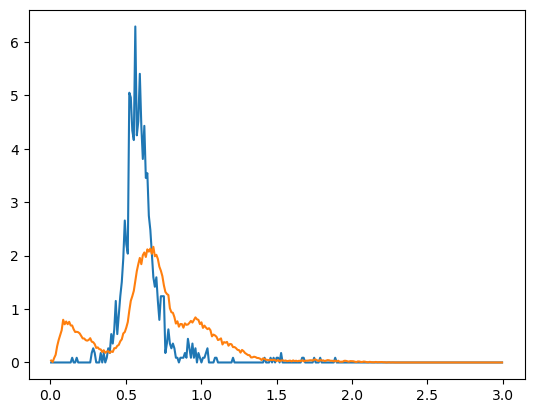

In [ ]:
import h5py
import matplotlib.pyplot as plt

filepath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/BOSS/output_estimate_TrainZ.hdf5"
file = h5py.File(filepath)
filepath2 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/DEEP2/output_estimate_TrainZ.hdf5"
file2 = h5py.File(filepath2)

plt.plot(file['meta']['xvals'][0], file['data']['yvals'][2])
plt.plot(file2['meta']['xvals'][0], file2['data']['yvals'][2])

# Visualizing Training Sets 

In [9]:
import numpy as np

def removeNans(df): 
    lsu = df.index[np.isnan(df['mag_u_lsst']) ==True].tolist() 
    lsg = df.index[np.isnan(df['mag_g_lsst']) ==True].tolist() 
    lsr = df.index[np.isnan(df['mag_r_lsst']) ==True].tolist() 
    lsi = df.index[np.isnan(df['mag_i_lsst']) ==True].tolist() 
    lsz = df.index[np.isnan(df['mag_z_lsst']) ==True].tolist() 
    lsy = df.index[np.isnan(df['mag_y_lsst']) ==True].tolist() 

    nans = list(set(lsu+lsg+lsr+lsi+lsz+lsy))
    new_df = df.drop(nans)

    return new_df 

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

spec_set = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/BOSS/output_spec_train_set.pq') ) 
boss_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/BOSS/output_lsst_error_0.pq') ) 
deep2_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/DEEP2/output_lsst_error_0.pq') ) 
gama_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/GAMA/output_lsst_error_0.pq') ) 
hsc_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/HSC/output_lsst_error_0.pq') ) 
vvdsf02_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/VVDSf02/output_lsst_error_0.pq') ) 
zcosmos_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/zCOSMOS/output_lsst_error_0.pq') ) 

invz_set = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/invz=1.0/output_invz_train_set.pq') ) 
one_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/invz=1.0/output_lsst_error_0.pq') ) 
onefour_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/invz=1.4/output_lsst_error_0.pq') ) 
lssterr_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/lsstErr_only/output_lsst_error_0.pq'))
control_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/control/output_lsst_error_null.pq'))


Text(0.02, 0.5, 'Magnitude')

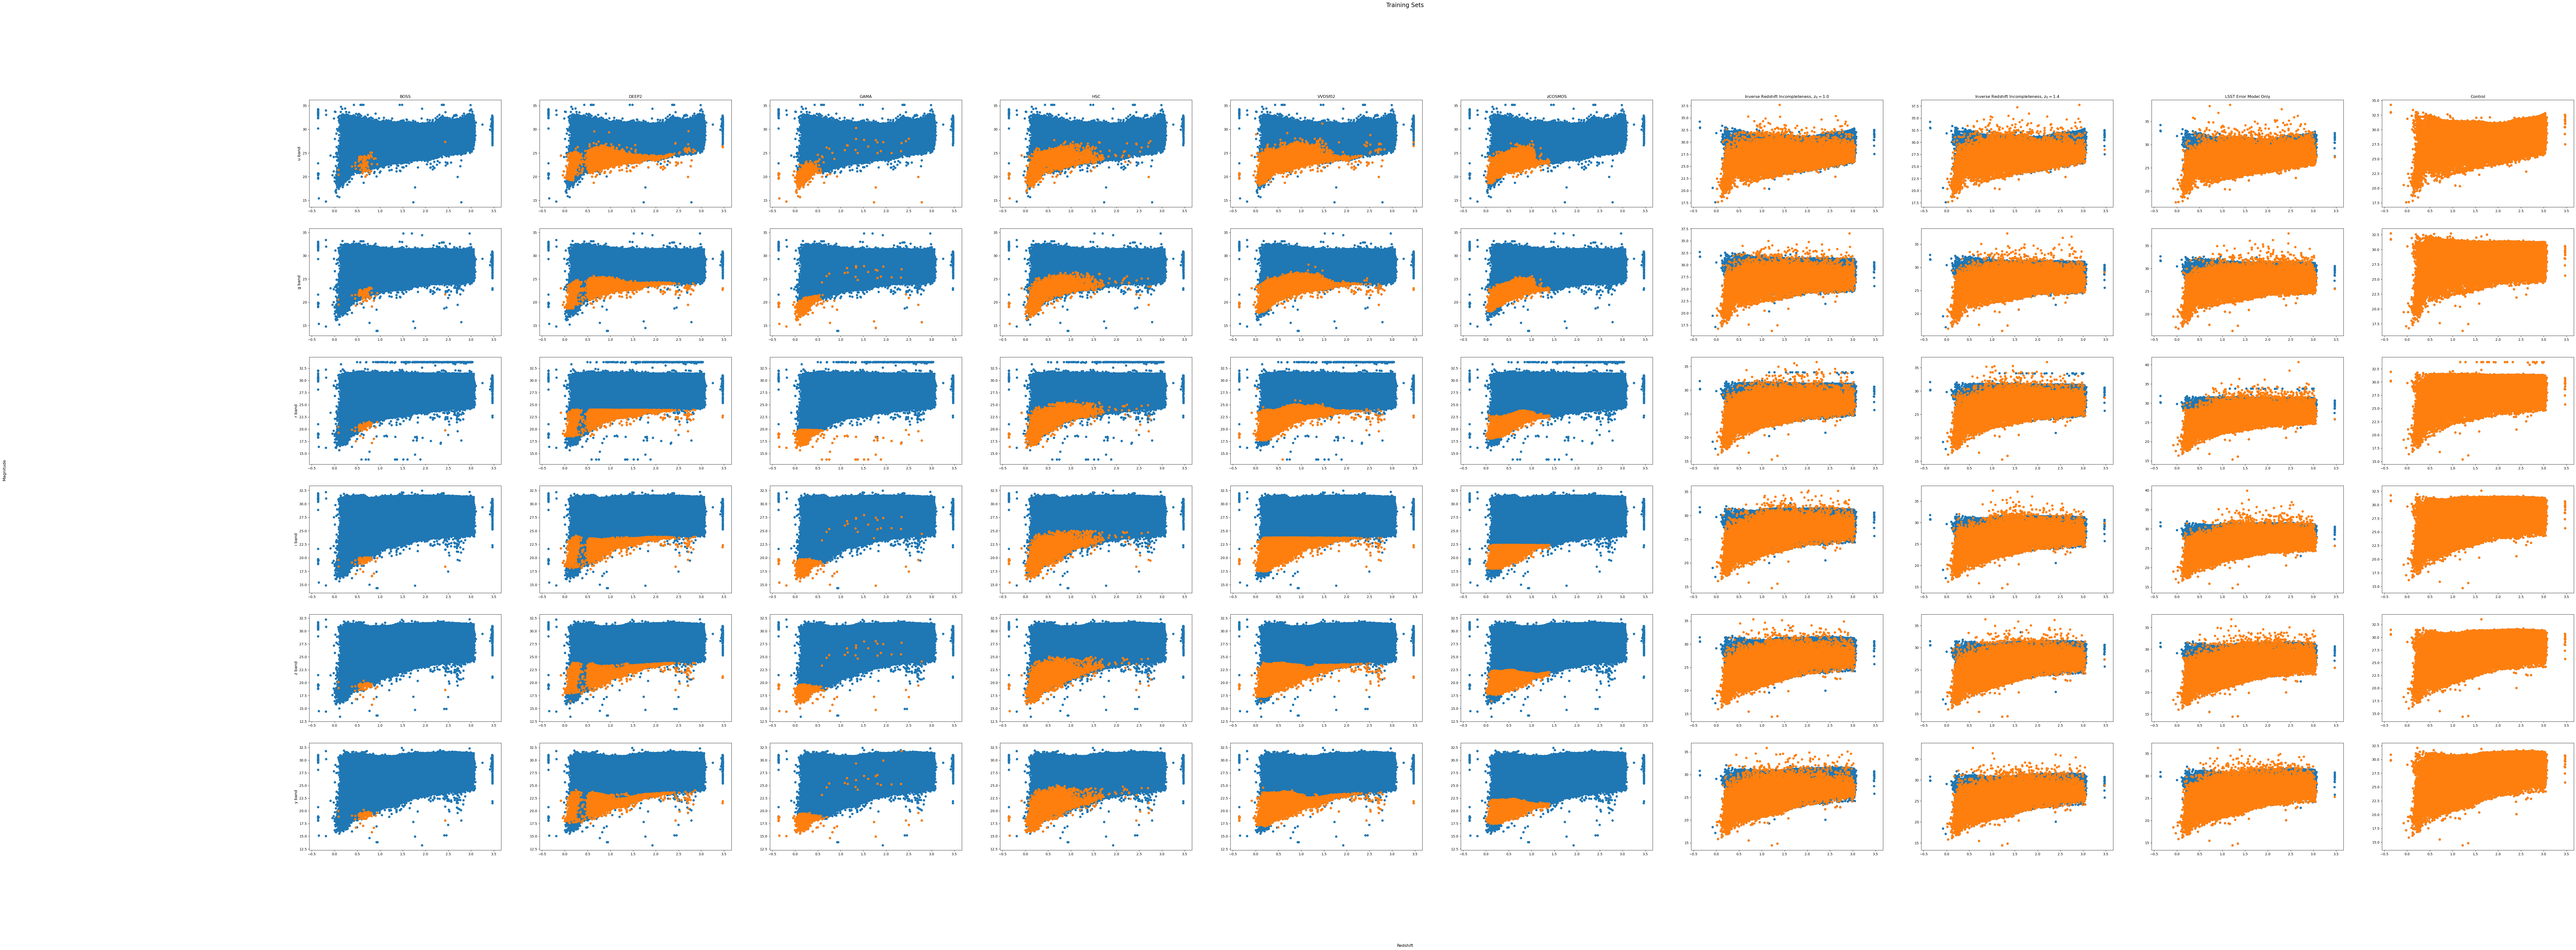

In [13]:
fig, axes = plt.subplots(nrows = 6, ncols = 10, figsize = (120, 40))
bands = ['u', 'g', 'r', 'i', 'z', 'y']
ct = 0
for band in bands: 
    axes[ct][0].scatter(spec_set['redshift'], spec_set['mag_'+band+'_lsst'])
    axes[ct][0].scatter(boss_deg['redshift'], boss_deg['mag_'+band+'_lsst'])
    # axes[ct][0].hist2d(boss_deg['redshift'], boss_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 30, 100)), density = True)

    axes[ct][1].scatter(spec_set['redshift'], spec_set['mag_'+band+'_lsst'])
    axes[ct][1].scatter(deep2_deg['redshift'], deep2_deg['mag_'+band+'_lsst'])
    # axes[ct][1].hist2d(deep2_deg['redshift'], deep2_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 30, 100)), density = True)

    axes[ct][2].scatter(spec_set['redshift'], spec_set['mag_'+band+'_lsst'])
    axes[ct][2].scatter(gama_deg['redshift'], gama_deg['mag_'+band+'_lsst'])
    # axes[ct][2].hist2d(gama_deg['redshift'], gama_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 30, 100)), density = True)

    axes[ct][3].scatter(spec_set['redshift'], spec_set['mag_'+band+'_lsst'])
    axes[ct][3].scatter(hsc_deg['redshift'], hsc_deg['mag_'+band+'_lsst'])
    # axes[ct][3].hist2d(hsc_deg['redshift'], hsc_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 30, 100)), density = True)

    axes[ct][4].scatter(spec_set['redshift'], spec_set['mag_'+band+'_lsst'])
    axes[ct][4].scatter(vvdsf02_deg['redshift'], vvdsf02_deg['mag_'+band+'_lsst'])
    # axes[ct][4].hist2d(vvdsf02_deg['redshift'], vvdsf02_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 30, 100)), density = True)

    axes[ct][5].scatter(spec_set['redshift'], spec_set['mag_'+band+'_lsst'])
    axes[ct][5].scatter(zcosmos_deg['redshift'], zcosmos_deg['mag_'+band+'_lsst'])
    # axes[ct][5].hist2d(zcosmos_deg['redshift'], zcosmos_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 30, 100)), density = True)


    axes[ct][6].scatter(invz_set['redshift'], invz_set['mag_'+band+'_lsst'])
    axes[ct][6].scatter(one_deg['redshift'], one_deg['mag_'+band+'_lsst'])
    # axes[ct][6].hist2d(one_deg['redshift'], one_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 30, 100)), density = True)

    axes[ct][7].scatter(invz_set['redshift'], invz_set['mag_'+band+'_lsst'])
    axes[ct][7].scatter(onefour_deg['redshift'], onefour_deg['mag_'+band+'_lsst'])
    # axes[ct][7].hist2d(onefour_deg['redshift'], onefour_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 30, 100)), density = True)

    axes[ct][8].scatter(invz_set['redshift'], invz_set['mag_'+band+'_lsst'])
    axes[ct][8].scatter(lssterr_deg['redshift'], lssterr_deg['mag_'+band+'_lsst'])
    # axes[ct][8].hist2d(lssterr_deg['redshift'], lssterr_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 30, 100)), density = True)

    axes[ct][9].scatter(invz_set['redshift'], invz_set['mag_'+band+'_lsst'])
    axes[ct][9].scatter(control_deg['redshift'], control_deg['mag_'+band+'_lsst'])
    # axes[ct][9].hist2d(control_deg['redshift'], control_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 30, 100)), density = True)


    ct += 1

axes[0][0].set_title("BOSS", size = 'large')
axes[0][1].set_title("DEEP2", size = 'large')
axes[0][2].set_title("GAMA", size = 'large')
axes[0][3].set_title("HSC", size = 'large')
axes[0][4].set_title("VVDSf02", size = 'large')
axes[0][5].set_title("zCOSMOS", size = 'large')
axes[0][6].set_title("Inverse Redshift Incompleteness, $z_0 = 1.0$", size = 'large')
axes[0][7].set_title("Inverse Redshift Incompleteness, $z_0 = 1.4$", size = 'large')
axes[0][8].set_title("LSST Error Model Only", size = 'large')
axes[0][9].set_title("Control", size = 'large')

axes[0][0].set_ylabel('u band', size = 'large')
axes[1][0].set_ylabel('g band', size = 'large')
axes[2][0].set_ylabel('r band', size = 'large')
axes[3][0].set_ylabel('i band', size = 'large')
axes[4][0].set_ylabel('z band', size = 'large')
axes[5][0].set_ylabel('y band', size = 'large')

fig.suptitle("Training Sets", size = "xx-large")
fig.supxlabel("Redshift", size = 'large')
fig.supylabel("Magnitude", size = 'large')

In [78]:
one_deg

,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,2.436975,30.940762,30.468155,30.532877,30.583982,30.670523,30.623058
1,1.088982,27.591162,27.652189,27.638281,27.431826,26.947683,26.807861
3,1.416708,26.176752,26.111094,26.222506,26.118505,25.999004,25.548321
4,2.497057,31.679161,31.123859,31.204720,31.239487,31.327595,31.312077
5,2.549719,28.945997,28.376080,28.497013,28.521559,28.614952,28.631378
...,...,...,...,...,...,...,...
99989,1.950511,27.695206,27.917601,27.929848,28.028337,27.964928,27.904871
99991,0.880302,26.729832,26.818487,26.697842,26.177248,25.950722,25.866610
99996,1.114324,28.011086,28.061989,28.063637,27.896845,27.394476,27.270678
99997,0.522832,23.949120,23.815697,23.183819,22.848392,22.901430,22.678867


In [79]:
onefour_deg

,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,2.436975,30.940762,30.468155,30.532877,30.583982,30.670523,30.623058
1,1.088982,27.591162,27.652189,27.638281,27.431826,26.947683,26.807861
2,1.592498,28.611349,28.522144,28.600510,28.551346,28.449226,28.233229
3,1.416708,26.176752,26.111094,26.222506,26.118505,25.999004,25.548321
4,2.497057,31.679161,31.123859,31.204720,31.239487,31.327595,31.312077
...,...,...,...,...,...,...,...
99995,2.167174,27.258110,26.951733,26.503679,26.307100,26.113443,25.853886
99996,1.114324,28.011086,28.061989,28.063637,27.896845,27.394476,27.270678
99997,0.522832,23.949120,23.815697,23.183819,22.848392,22.901430,22.678867
99998,1.510567,26.471224,26.397249,26.502960,26.439993,26.363508,26.007662
